In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f"Using device : {device}")

Using device : cuda


In [3]:
torch.manual_seed(42)

In [4]:
import kagglehub
path = kagglehub.dataset_download("zalando-research/fashionmnist")
df = pd.read_csv(path + '/fashion-mnist_train.csv')

Using Colab cache for faster access to the 'fashionmnist' dataset.


In [5]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


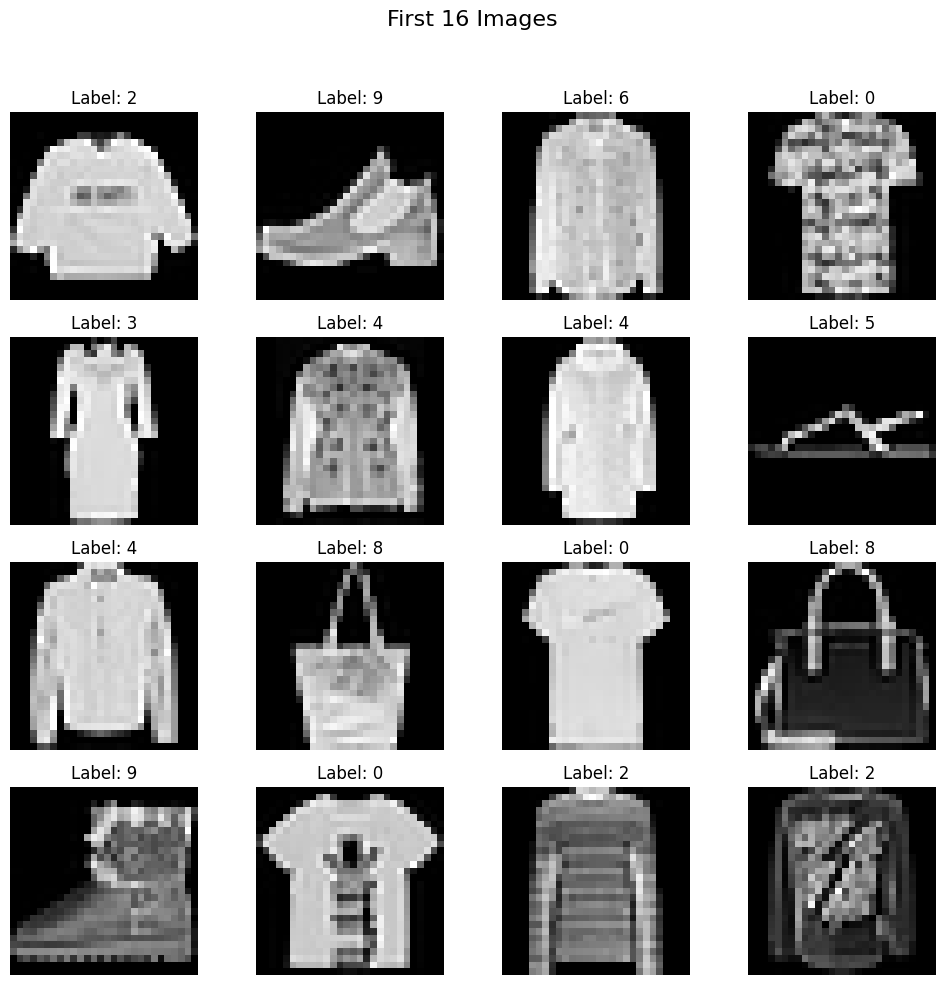

In [6]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plotting the images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {df.iloc[i, 0]}")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # top reserved for title
plt.show()

In [7]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train = X_train/255.0
X_test = X_test/255.0

In [10]:
from torch.utils.data import Dataset
import torch

class CustomDataset(Dataset):

    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [11]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

# Loader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

In [12]:
# Defining NN class
class MyNN(nn.Module):
    
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

In [13]:
# set Learning Rate
epochs = 100
learning_rate = 0.1

In [14]:
model = MyNN(X_train.shape[1]).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
train_losses = []

for epoch in range(epochs):

    total_epochs_loss = 0

    for batch_features, batch_labels in train_loader:

        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epochs_loss += loss.item()

    avg_loss = total_epochs_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


Epoch [1/100], Loss: 0.9020
Epoch [2/100], Loss: 0.5294
Epoch [3/100], Loss: 0.4629
Epoch [4/100], Loss: 0.4251
Epoch [5/100], Loss: 0.4022
Epoch [6/100], Loss: 0.3852
Epoch [7/100], Loss: 0.3661
Epoch [8/100], Loss: 0.3545
Epoch [9/100], Loss: 0.3427
Epoch [10/100], Loss: 0.3335
Epoch [11/100], Loss: 0.3236
Epoch [12/100], Loss: 0.3128
Epoch [13/100], Loss: 0.3072
Epoch [14/100], Loss: 0.2976
Epoch [15/100], Loss: 0.2945
Epoch [16/100], Loss: 0.2872
Epoch [17/100], Loss: 0.2799
Epoch [18/100], Loss: 0.2737
Epoch [19/100], Loss: 0.2705
Epoch [20/100], Loss: 0.2646
Epoch [21/100], Loss: 0.2581
Epoch [22/100], Loss: 0.2534
Epoch [23/100], Loss: 0.2482
Epoch [24/100], Loss: 0.2427
Epoch [25/100], Loss: 0.2396
Epoch [26/100], Loss: 0.2346
Epoch [27/100], Loss: 0.2310
Epoch [28/100], Loss: 0.2274
Epoch [29/100], Loss: 0.2246
Epoch [30/100], Loss: 0.2193
Epoch [31/100], Loss: 0.2148
Epoch [32/100], Loss: 0.2124
Epoch [33/100], Loss: 0.2080
Epoch [34/100], Loss: 0.2059
Epoch [35/100], Loss: 0

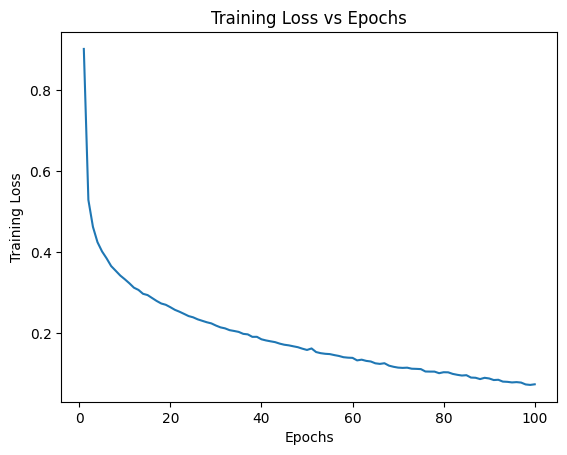

In [16]:
plt.figure()
plt.plot(range(1, epochs + 1), train_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.show()

In [17]:
# evaluation code
model.eval()
total = 0
correct = 0

with torch.no_grad():

    for batch_features, batch_labels in test_loader:

        # Move data to gpu
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)

        _, predicted = torch.max(outputs, 1)

        total = total + batch_features.shape[0]

        correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.88675
